In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


Loaded 78017 images
Dataset type test label type: species


Loaded 81589 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 nrr31vzi


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nrr31vzi:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1186 [00:00<12:42,  1.55it/s]

  0%|▌                                                                                                                                         | 5/1186 [00:00<02:18,  8.54it/s]

  1%|█▏                                                                                                                                       | 10/1186 [00:00<01:09, 16.82it/s]

  1%|█▋                                                                                                                                       | 15/1186 [00:00<00:48, 24.08it/s]

  2%|██▎                                                                                                                                      | 20/1186 [00:01<00:38, 30.24it/s]

  2%|██▉                                                                                                                                      | 25/1186 [00:01<00:33, 34.99it/s]

  3%|███▍                                                                                                                                     | 30/1186 [00:01<00:29, 38.96it/s]

  3%|████                                                                                                                                     | 35/1186 [00:01<00:27, 41.73it/s]

  3%|████▌                                                                                                                                    | 40/1186 [00:01<00:26, 43.71it/s]

  4%|█████▏                                                                                                                                   | 45/1186 [00:01<00:25, 45.05it/s]

  4%|█████▊                                                                                                                                   | 50/1186 [00:01<00:24, 46.20it/s]

  5%|██████▎                                                                                                                                  | 55/1186 [00:01<00:23, 47.13it/s]

  5%|██████▉                                                                                                                                  | 60/1186 [00:01<00:23, 47.80it/s]

  5%|███████▌                                                                                                                                 | 65/1186 [00:01<00:23, 48.25it/s]

  6%|████████                                                                                                                                 | 70/1186 [00:02<00:22, 48.58it/s]

  6%|████████▋                                                                                                                                | 75/1186 [00:02<00:22, 48.81it/s]

  7%|█████████▏                                                                                                                               | 80/1186 [00:02<00:22, 48.99it/s]

  7%|█████████▊                                                                                                                               | 85/1186 [00:02<00:22, 49.13it/s]

  8%|██████████▍                                                                                                                              | 90/1186 [00:02<00:22, 49.22it/s]

  8%|██████████▉                                                                                                                              | 95/1186 [00:02<00:22, 49.24it/s]

  8%|███████████▍                                                                                                                            | 100/1186 [00:02<00:22, 49.30it/s]

  9%|████████████                                                                                                                            | 105/1186 [00:02<00:21, 49.22it/s]

  9%|████████████▌                                                                                                                           | 110/1186 [00:02<00:21, 49.26it/s]

 10%|█████████████▏                                                                                                                          | 115/1186 [00:02<00:21, 49.31it/s]

 10%|█████████████▊                                                                                                                          | 120/1186 [00:03<00:21, 49.32it/s]

 11%|██████████████▎                                                                                                                         | 125/1186 [00:03<00:21, 49.34it/s]

 11%|██████████████▉                                                                                                                         | 130/1186 [00:03<00:21, 49.38it/s]

 11%|███████████████▍                                                                                                                        | 135/1186 [00:03<00:21, 49.40it/s]

 12%|████████████████                                                                                                                        | 140/1186 [00:03<00:21, 49.42it/s]

 12%|████████████████▋                                                                                                                       | 145/1186 [00:03<00:21, 49.27it/s]

 13%|█████████████████▏                                                                                                                      | 150/1186 [00:03<00:21, 49.28it/s]

 13%|█████████████████▊                                                                                                                      | 155/1186 [00:03<00:20, 49.34it/s]

 13%|██████████████████▎                                                                                                                     | 160/1186 [00:03<00:20, 49.19it/s]

 14%|██████████████████▉                                                                                                                     | 165/1186 [00:04<00:20, 49.06it/s]

 14%|███████████████████▍                                                                                                                    | 170/1186 [00:04<00:20, 48.97it/s]

 15%|████████████████████                                                                                                                    | 175/1186 [00:04<00:20, 48.90it/s]

 15%|████████████████████▋                                                                                                                   | 180/1186 [00:04<00:20, 48.89it/s]

 16%|█████████████████████▏                                                                                                                  | 185/1186 [00:04<00:20, 48.86it/s]

 16%|█████████████████████▊                                                                                                                  | 190/1186 [00:04<00:20, 48.84it/s]

 16%|██████████████████████▎                                                                                                                 | 195/1186 [00:04<00:20, 48.83it/s]

 17%|██████████████████████▉                                                                                                                 | 200/1186 [00:04<00:20, 48.81it/s]

 17%|███████████████████████▌                                                                                                                | 205/1186 [00:04<00:20, 48.83it/s]

 18%|████████████████████████                                                                                                                | 210/1186 [00:04<00:19, 48.84it/s]

 18%|████████████████████████▋                                                                                                               | 215/1186 [00:05<00:19, 48.84it/s]

 19%|█████████████████████████▏                                                                                                              | 220/1186 [00:05<00:19, 48.81it/s]

 19%|█████████████████████████▉                                                                                                              | 226/1186 [00:05<00:19, 49.52it/s]

 20%|██████████████████████████▌                                                                                                             | 232/1186 [00:05<00:19, 50.08it/s]

 20%|███████████████████████████▎                                                                                                            | 238/1186 [00:05<00:18, 50.47it/s]

 21%|███████████████████████████▉                                                                                                            | 244/1186 [00:05<00:18, 50.62it/s]

 21%|████████████████████████████▋                                                                                                           | 250/1186 [00:05<00:18, 50.78it/s]

 22%|█████████████████████████████▎                                                                                                          | 256/1186 [00:05<00:18, 50.41it/s]

 22%|██████████████████████████████                                                                                                          | 262/1186 [00:05<00:18, 49.87it/s]

 23%|██████████████████████████████▌                                                                                                         | 267/1186 [00:06<00:18, 49.62it/s]

 23%|███████████████████████████████▏                                                                                                        | 272/1186 [00:06<00:18, 49.36it/s]

 23%|███████████████████████████████▊                                                                                                        | 277/1186 [00:06<00:18, 49.12it/s]

 24%|████████████████████████████████▎                                                                                                       | 282/1186 [00:06<00:18, 49.02it/s]

 24%|████████████████████████████████▉                                                                                                       | 287/1186 [00:06<00:18, 48.97it/s]

 25%|█████████████████████████████████▍                                                                                                      | 292/1186 [00:06<00:18, 48.95it/s]

 25%|██████████████████████████████████                                                                                                      | 297/1186 [00:06<00:18, 48.94it/s]

 25%|██████████████████████████████████▋                                                                                                     | 302/1186 [00:06<00:18, 48.92it/s]

 26%|███████████████████████████████████▏                                                                                                    | 307/1186 [00:06<00:17, 48.91it/s]

 26%|███████████████████████████████████▊                                                                                                    | 312/1186 [00:06<00:17, 48.75it/s]

 27%|████████████████████████████████████▎                                                                                                   | 317/1186 [00:07<00:17, 48.76it/s]

 27%|█████████████████████████████████████                                                                                                   | 323/1186 [00:07<00:17, 49.24it/s]

 28%|█████████████████████████████████████▌                                                                                                  | 328/1186 [00:07<00:17, 49.02it/s]

 28%|██████████████████████████████████████▏                                                                                                 | 333/1186 [00:07<00:17, 49.03it/s]

 28%|██████████████████████████████████████▊                                                                                                 | 338/1186 [00:07<00:17, 48.85it/s]

 29%|███████████████████████████████████████▎                                                                                                | 343/1186 [00:07<00:17, 48.86it/s]

 29%|███████████████████████████████████████▉                                                                                                | 348/1186 [00:07<00:17, 48.87it/s]

 30%|████████████████████████████████████████▍                                                                                               | 353/1186 [00:07<00:17, 48.86it/s]

 30%|█████████████████████████████████████████                                                                                               | 358/1186 [00:07<00:16, 48.89it/s]

 31%|█████████████████████████████████████████▋                                                                                              | 363/1186 [00:08<00:16, 48.96it/s]

 31%|██████████████████████████████████████████▏                                                                                             | 368/1186 [00:08<00:16, 48.94it/s]

 31%|██████████████████████████████████████████▊                                                                                             | 373/1186 [00:08<00:16, 48.94it/s]

 32%|███████████████████████████████████████████▎                                                                                            | 378/1186 [00:08<00:16, 48.92it/s]

 32%|███████████████████████████████████████████▉                                                                                            | 383/1186 [00:08<00:16, 48.95it/s]

 33%|████████████████████████████████████████████▍                                                                                           | 388/1186 [00:08<00:16, 48.99it/s]

 33%|█████████████████████████████████████████████                                                                                           | 393/1186 [00:08<00:16, 49.02it/s]

 34%|█████████████████████████████████████████████▋                                                                                          | 398/1186 [00:08<00:16, 49.18it/s]

 34%|██████████████████████████████████████████████▏                                                                                         | 403/1186 [00:08<00:15, 49.26it/s]

 34%|██████████████████████████████████████████████▊                                                                                         | 408/1186 [00:08<00:15, 49.20it/s]

 35%|███████████████████████████████████████████████▎                                                                                        | 413/1186 [00:09<00:15, 49.13it/s]

 35%|███████████████████████████████████████████████▉                                                                                        | 418/1186 [00:09<00:15, 49.07it/s]

 36%|████████████████████████████████████████████████▌                                                                                       | 423/1186 [00:09<00:15, 49.04it/s]

 36%|█████████████████████████████████████████████████                                                                                       | 428/1186 [00:09<00:15, 49.00it/s]

 37%|█████████████████████████████████████████████████▋                                                                                      | 433/1186 [00:09<00:15, 48.98it/s]

 37%|██████████████████████████████████████████████████▏                                                                                     | 438/1186 [00:09<00:15, 48.98it/s]

 37%|██████████████████████████████████████████████████▊                                                                                     | 443/1186 [00:09<00:15, 48.82it/s]

 38%|███████████████████████████████████████████████████▎                                                                                    | 448/1186 [00:09<00:15, 48.84it/s]

 38%|███████████████████████████████████████████████████▉                                                                                    | 453/1186 [00:09<00:15, 48.75it/s]

 39%|████████████████████████████████████████████████████▌                                                                                   | 458/1186 [00:09<00:14, 48.97it/s]

 39%|█████████████████████████████████████████████████████                                                                                   | 463/1186 [00:10<00:14, 49.00it/s]

 39%|█████████████████████████████████████████████████████▋                                                                                  | 468/1186 [00:10<00:14, 49.10it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                 | 473/1186 [00:10<00:14, 49.23it/s]

 40%|██████████████████████████████████████████████████████▊                                                                                 | 478/1186 [00:10<00:14, 49.26it/s]

 41%|███████████████████████████████████████████████████████▍                                                                                | 483/1186 [00:10<00:14, 49.31it/s]

 41%|███████████████████████████████████████████████████████▉                                                                                | 488/1186 [00:10<00:14, 49.36it/s]

 42%|████████████████████████████████████████████████████████▌                                                                               | 493/1186 [00:10<00:14, 49.40it/s]

 42%|█████████████████████████████████████████████████████████                                                                               | 498/1186 [00:10<00:13, 49.44it/s]

 42%|█████████████████████████████████████████████████████████▋                                                                              | 503/1186 [00:10<00:13, 49.28it/s]

 43%|██████████████████████████████████████████████████████████▎                                                                             | 508/1186 [00:10<00:13, 49.32it/s]

 43%|██████████████████████████████████████████████████████████▊                                                                             | 513/1186 [00:11<00:13, 49.33it/s]

 44%|███████████████████████████████████████████████████████████▍                                                                            | 518/1186 [00:11<00:13, 49.41it/s]

 44%|███████████████████████████████████████████████████████████▉                                                                            | 523/1186 [00:11<00:13, 49.43it/s]

 45%|████████████████████████████████████████████████████████████▌                                                                           | 528/1186 [00:11<00:13, 49.46it/s]

 45%|█████████████████████████████████████████████████████████████                                                                           | 533/1186 [00:11<00:13, 49.43it/s]

 45%|█████████████████████████████████████████████████████████████▋                                                                          | 538/1186 [00:11<00:13, 49.46it/s]

 46%|██████████████████████████████████████████████████████████████▎                                                                         | 543/1186 [00:11<00:12, 49.48it/s]

 46%|██████████████████████████████████████████████████████████████▊                                                                         | 548/1186 [00:11<00:12, 49.51it/s]

 47%|███████████████████████████████████████████████████████████████▍                                                                        | 553/1186 [00:11<00:12, 49.52it/s]

 47%|███████████████████████████████████████████████████████████████▉                                                                        | 558/1186 [00:11<00:12, 49.46it/s]

 47%|████████████████████████████████████████████████████████████████▌                                                                       | 563/1186 [00:12<00:12, 49.45it/s]

 48%|█████████████████████████████████████████████████████████████████▏                                                                      | 568/1186 [00:12<00:12, 49.30it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                      | 573/1186 [00:12<00:12, 49.37it/s]

 49%|██████████████████████████████████████████████████████████████████▎                                                                     | 578/1186 [00:12<00:12, 49.49it/s]

 49%|██████████████████████████████████████████████████████████████████▊                                                                     | 583/1186 [00:12<00:12, 49.27it/s]

 50%|███████████████████████████████████████████████████████████████████▍                                                                    | 588/1186 [00:12<00:12, 49.12it/s]

 50%|████████████████████████████████████████████████████████████████████                                                                    | 593/1186 [00:12<00:12, 49.24it/s]

 50%|████████████████████████████████████████████████████████████████████▌                                                                   | 598/1186 [00:12<00:11, 49.30it/s]

 51%|█████████████████████████████████████████████████████████████████████▏                                                                  | 603/1186 [00:12<00:11, 49.36it/s]

 51%|█████████████████████████████████████████████████████████████████████▋                                                                  | 608/1186 [00:13<00:11, 49.38it/s]

 52%|██████████████████████████████████████████████████████████████████████▎                                                                 | 613/1186 [00:13<00:11, 49.40it/s]

 52%|██████████████████████████████████████████████████████████████████████▊                                                                 | 618/1186 [00:13<00:11, 49.42it/s]

 53%|███████████████████████████████████████████████████████████████████████▍                                                                | 623/1186 [00:13<00:11, 49.43it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                | 628/1186 [00:13<00:11, 49.44it/s]

 53%|████████████████████████████████████████████████████████████████████████▌                                                               | 633/1186 [00:13<00:11, 49.44it/s]

 54%|█████████████████████████████████████████████████████████████████████████▏                                                              | 638/1186 [00:13<00:11, 49.43it/s]

 54%|█████████████████████████████████████████████████████████████████████████▋                                                              | 643/1186 [00:13<00:10, 49.46it/s]

 55%|██████████████████████████████████████████████████████████████████████████▎                                                             | 648/1186 [00:13<00:10, 49.31it/s]

 55%|██████████████████████████████████████████████████████████████████████████▉                                                             | 653/1186 [00:13<00:10, 49.44it/s]

 55%|███████████████████████████████████████████████████████████████████████████▍                                                            | 658/1186 [00:14<00:10, 49.43it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                            | 663/1186 [00:14<00:10, 49.42it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                           | 668/1186 [00:14<00:10, 49.42it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▏                                                          | 673/1186 [00:14<00:10, 49.45it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 678/1186 [00:14<00:10, 49.46it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▎                                                         | 683/1186 [00:14<00:10, 49.52it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▉                                                         | 688/1186 [00:14<00:10, 49.33it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▍                                                        | 693/1186 [00:14<00:10, 49.18it/s]

 59%|████████████████████████████████████████████████████████████████████████████████                                                        | 698/1186 [00:14<00:09, 49.10it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▌                                                       | 703/1186 [00:14<00:10, 47.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▏                                                      | 708/1186 [00:15<00:09, 48.00it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                      | 713/1186 [00:15<00:09, 48.23it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                     | 718/1186 [00:15<00:09, 48.42it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                     | 723/1186 [00:15<00:09, 48.58it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                    | 728/1186 [00:15<00:09, 48.62it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                    | 733/1186 [00:15<00:09, 48.72it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                   | 738/1186 [00:15<00:09, 48.77it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▏                                                  | 743/1186 [00:15<00:09, 48.80it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                  | 748/1186 [00:15<00:08, 48.83it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                 | 753/1186 [00:15<00:08, 48.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                 | 758/1186 [00:16<00:08, 48.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                | 763/1186 [00:16<00:08, 48.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████                                                | 768/1186 [00:16<00:08, 48.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▋                                               | 773/1186 [00:16<00:08, 48.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▏                                              | 778/1186 [00:16<00:08, 48.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                              | 783/1186 [00:16<00:08, 48.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▎                                             | 788/1186 [00:16<00:08, 48.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▉                                             | 793/1186 [00:16<00:08, 48.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                            | 798/1186 [00:16<00:07, 48.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████                                            | 803/1186 [00:16<00:07, 48.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 808/1186 [00:17<00:07, 48.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 813/1186 [00:17<00:07, 48.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 818/1186 [00:17<00:07, 48.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 823/1186 [00:17<00:07, 48.60it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 828/1186 [00:17<00:07, 48.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 833/1186 [00:17<00:07, 48.77it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████                                        | 838/1186 [00:17<00:07, 48.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 843/1186 [00:17<00:07, 48.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 848/1186 [00:17<00:06, 48.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 853/1186 [00:18<00:06, 48.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 858/1186 [00:18<00:06, 48.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 863/1186 [00:18<00:06, 48.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 868/1186 [00:18<00:06, 48.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 873/1186 [00:18<00:06, 48.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 878/1186 [00:18<00:06, 48.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 883/1186 [00:18<00:06, 48.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 888/1186 [00:18<00:06, 48.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 893/1186 [00:18<00:06, 48.79it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 898/1186 [00:18<00:05, 48.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 903/1186 [00:19<00:05, 48.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 908/1186 [00:19<00:05, 48.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 913/1186 [00:19<00:05, 48.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 918/1186 [00:19<00:05, 48.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 923/1186 [00:19<00:05, 48.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 929/1186 [00:19<00:05, 49.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 934/1186 [00:19<00:05, 49.01it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 939/1186 [00:19<00:05, 48.97it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 944/1186 [00:19<00:04, 48.94it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 949/1186 [00:19<00:04, 48.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 954/1186 [00:20<00:04, 48.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 959/1186 [00:20<00:04, 48.94it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 964/1186 [00:20<00:04, 48.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 969/1186 [00:20<00:04, 48.93it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 974/1186 [00:20<00:04, 48.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 979/1186 [00:20<00:04, 48.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 984/1186 [00:20<00:04, 48.91it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 989/1186 [00:20<00:04, 48.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 994/1186 [00:20<00:03, 48.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 999/1186 [00:20<00:03, 48.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1004/1186 [00:21<00:03, 48.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1009/1186 [00:21<00:03, 48.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1014/1186 [00:21<00:03, 48.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1019/1186 [00:21<00:03, 49.10it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1024/1186 [00:21<00:03, 49.17it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1029/1186 [00:21<00:03, 49.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1034/1186 [00:21<00:03, 49.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1039/1186 [00:21<00:02, 49.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1045/1186 [00:21<00:02, 49.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1050/1186 [00:22<00:02, 49.40it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1055/1186 [00:22<00:02, 49.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1060/1186 [00:22<00:02, 49.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1065/1186 [00:22<00:02, 49.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1070/1186 [00:22<00:02, 49.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1075/1186 [00:22<00:02, 49.45it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1080/1186 [00:22<00:02, 49.41it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1085/1186 [00:22<00:02, 49.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1090/1186 [00:22<00:01, 49.42it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1095/1186 [00:22<00:01, 49.32it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1100/1186 [00:23<00:01, 49.37it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1105/1186 [00:23<00:01, 49.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1110/1186 [00:23<00:01, 49.40it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1115/1186 [00:23<00:01, 49.44it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1120/1186 [00:23<00:01, 49.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1125/1186 [00:23<00:01, 49.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1130/1186 [00:23<00:01, 49.44it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1135/1186 [00:23<00:01, 49.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1140/1186 [00:23<00:00, 49.41it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1145/1186 [00:23<00:00, 49.40it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1150/1186 [00:24<00:00, 49.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1155/1186 [00:24<00:00, 49.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1160/1186 [00:24<00:00, 49.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1165/1186 [00:24<00:00, 49.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1170/1186 [00:24<00:00, 49.30it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1175/1186 [00:24<00:00, 49.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1180/1186 [00:24<00:00, 48.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [00:24<00:00, 48.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:24<00:00, 47.74it/s]

train - OK


  0%|                                                                                                                                                   | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                          | 1/297 [00:00<00:58,  5.02it/s]

  2%|██▊                                                                                                                                        | 6/297 [00:00<00:12, 23.47it/s]

  4%|█████                                                                                                                                     | 11/297 [00:00<00:08, 32.99it/s]

  5%|███████▍                                                                                                                                  | 16/297 [00:00<00:07, 38.63it/s]

  7%|█████████▊                                                                                                                                | 21/297 [00:00<00:06, 42.04it/s]

  9%|████████████                                                                                                                              | 26/297 [00:00<00:06, 44.26it/s]

 10%|██████████████▍                                                                                                                           | 31/297 [00:00<00:05, 45.82it/s]

 12%|████████████████▋                                                                                                                         | 36/297 [00:00<00:05, 46.90it/s]

 14%|███████████████████                                                                                                                       | 41/297 [00:01<00:05, 47.65it/s]

 15%|█████████████████████▎                                                                                                                    | 46/297 [00:01<00:05, 48.14it/s]

 17%|███████████████████████▋                                                                                                                  | 51/297 [00:01<00:05, 48.48it/s]

 19%|██████████████████████████                                                                                                                | 56/297 [00:01<00:04, 48.74it/s]

 21%|████████████████████████████▎                                                                                                             | 61/297 [00:01<00:04, 48.94it/s]

 22%|██████████████████████████████▋                                                                                                           | 66/297 [00:01<00:04, 48.91it/s]

 24%|████████████████████████████████▉                                                                                                         | 71/297 [00:01<00:04, 49.06it/s]

 26%|███████████████████████████████████▎                                                                                                      | 76/297 [00:01<00:04, 49.07it/s]

 27%|█████████████████████████████████████▋                                                                                                    | 81/297 [00:01<00:04, 49.14it/s]

 29%|███████████████████████████████████████▉                                                                                                  | 86/297 [00:01<00:04, 49.21it/s]

 31%|██████████████████████████████████████████▎                                                                                               | 91/297 [00:02<00:04, 49.25it/s]

 32%|████████████████████████████████████████████▌                                                                                             | 96/297 [00:02<00:04, 49.26it/s]

 34%|██████████████████████████████████████████████▌                                                                                          | 101/297 [00:02<00:03, 49.14it/s]

 36%|████████████████████████████████████████████████▉                                                                                        | 106/297 [00:02<00:03, 49.13it/s]

 37%|███████████████████████████████████████████████████▏                                                                                     | 111/297 [00:02<00:03, 49.21it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                   | 116/297 [00:02<00:03, 49.27it/s]

 41%|███████████████████████████████████████████████████████▊                                                                                 | 121/297 [00:02<00:03, 49.25it/s]

 42%|██████████████████████████████████████████████████████████                                                                               | 126/297 [00:02<00:03, 49.14it/s]

 44%|████████████████████████████████████████████████████████████▍                                                                            | 131/297 [00:02<00:03, 49.21it/s]

 46%|██████████████████████████████████████████████████████████████▋                                                                          | 136/297 [00:02<00:03, 49.24it/s]

 47%|█████████████████████████████████████████████████████████████████                                                                        | 141/297 [00:03<00:03, 49.29it/s]

 49%|███████████████████████████████████████████████████████████████████▎                                                                     | 146/297 [00:03<00:03, 49.27it/s]

 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 151/297 [00:03<00:02, 49.31it/s]

 53%|███████████████████████████████████████████████████████████████████████▉                                                                 | 156/297 [00:03<00:02, 49.31it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 161/297 [00:03<00:02, 49.32it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 166/297 [00:03<00:02, 49.30it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 171/297 [00:03<00:02, 49.31it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 176/297 [00:03<00:02, 49.31it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 181/297 [00:03<00:02, 49.13it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 186/297 [00:03<00:02, 49.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 191/297 [00:04<00:02, 49.22it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 196/297 [00:04<00:02, 49.21it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 201/297 [00:04<00:01, 49.22it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 206/297 [00:04<00:01, 49.11it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 211/297 [00:04<00:01, 49.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 216/297 [00:04<00:01, 49.13it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 221/297 [00:04<00:01, 49.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 226/297 [00:04<00:01, 49.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 231/297 [00:04<00:01, 49.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 236/297 [00:04<00:01, 49.15it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 241/297 [00:05<00:01, 49.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 246/297 [00:05<00:01, 49.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 251/297 [00:05<00:00, 49.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 256/297 [00:05<00:00, 49.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 261/297 [00:05<00:00, 49.30it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 266/297 [00:05<00:00, 49.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 271/297 [00:05<00:00, 49.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 276/297 [00:05<00:00, 49.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 281/297 [00:05<00:00, 49.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 286/297 [00:05<00:00, 49.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 291/297 [00:06<00:00, 49.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:06<00:00, 49.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:06<00:00, 47.10it/s]

val - OK


  0%|                                                                                                                                                   | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/610 [00:00<02:14,  4.51it/s]

  1%|█▎                                                                                                                                         | 6/610 [00:00<00:27, 21.81it/s]

  2%|██▍                                                                                                                                       | 11/610 [00:00<00:18, 31.57it/s]

  3%|███▌                                                                                                                                      | 16/610 [00:00<00:15, 37.33it/s]

  3%|████▊                                                                                                                                     | 21/610 [00:00<00:14, 41.02it/s]

  4%|█████▉                                                                                                                                    | 26/610 [00:00<00:13, 43.60it/s]

  5%|███████                                                                                                                                   | 31/610 [00:00<00:12, 45.33it/s]

  6%|████████▏                                                                                                                                 | 36/610 [00:00<00:12, 46.48it/s]

  7%|█████████▎                                                                                                                                | 41/610 [00:01<00:12, 47.29it/s]

  8%|██████████▍                                                                                                                               | 46/610 [00:01<00:11, 47.84it/s]

  8%|███████████▌                                                                                                                              | 51/610 [00:01<00:11, 48.24it/s]

  9%|████████████▋                                                                                                                             | 56/610 [00:01<00:11, 48.52it/s]

 10%|█████████████▊                                                                                                                            | 61/610 [00:01<00:11, 48.73it/s]

 11%|██████████████▉                                                                                                                           | 66/610 [00:01<00:11, 48.86it/s]

 12%|████████████████                                                                                                                          | 71/610 [00:01<00:11, 48.98it/s]

 12%|█████████████████▏                                                                                                                        | 76/610 [00:01<00:10, 49.03it/s]

 13%|██████████████████▎                                                                                                                       | 81/610 [00:01<00:10, 48.95it/s]

 14%|███████████████████▍                                                                                                                      | 86/610 [00:01<00:10, 49.01it/s]

 15%|████████████████████▌                                                                                                                     | 91/610 [00:02<00:10, 49.06it/s]

 16%|█████████████████████▋                                                                                                                    | 96/610 [00:02<00:10, 49.08it/s]

 17%|██████████████████████▋                                                                                                                  | 101/610 [00:02<00:10, 49.15it/s]

 17%|███████████████████████▊                                                                                                                 | 106/610 [00:02<00:10, 49.02it/s]

 18%|████████████████████████▉                                                                                                                | 111/610 [00:02<00:10, 48.93it/s]

 19%|██████████████████████████                                                                                                               | 116/610 [00:02<00:10, 48.85it/s]

 20%|███████████████████████████▏                                                                                                             | 121/610 [00:02<00:10, 48.75it/s]

 21%|████████████████████████████▎                                                                                                            | 126/610 [00:02<00:09, 48.71it/s]

 21%|█████████████████████████████▍                                                                                                           | 131/610 [00:02<00:09, 48.69it/s]

 22%|██████████████████████████████▌                                                                                                          | 136/610 [00:02<00:09, 48.55it/s]

 23%|███████████████████████████████▋                                                                                                         | 141/610 [00:03<00:09, 48.56it/s]

 24%|████████████████████████████████▊                                                                                                        | 146/610 [00:03<00:09, 48.56it/s]

 25%|█████████████████████████████████▉                                                                                                       | 151/610 [00:03<00:09, 48.58it/s]

 26%|███████████████████████████████████                                                                                                      | 156/610 [00:03<00:09, 48.60it/s]

 26%|████████████████████████████████████▏                                                                                                    | 161/610 [00:03<00:09, 48.62it/s]

 27%|█████████████████████████████████████▎                                                                                                   | 166/610 [00:03<00:09, 48.64it/s]

 28%|██████████████████████████████████████▍                                                                                                  | 171/610 [00:03<00:09, 48.65it/s]

 29%|███████████████████████████████████████▌                                                                                                 | 176/610 [00:03<00:08, 48.62it/s]

 30%|████████████████████████████████████████▋                                                                                                | 181/610 [00:03<00:08, 48.67it/s]

 30%|█████████████████████████████████████████▊                                                                                               | 186/610 [00:04<00:08, 48.68it/s]

 31%|██████████████████████████████████████████▉                                                                                              | 191/610 [00:04<00:08, 48.69it/s]

 32%|████████████████████████████████████████████                                                                                             | 196/610 [00:04<00:08, 48.51it/s]

 33%|█████████████████████████████████████████████▏                                                                                           | 201/610 [00:04<00:08, 48.44it/s]

 34%|██████████████████████████████████████████████▎                                                                                          | 206/610 [00:04<00:08, 48.50it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 211/610 [00:04<00:08, 48.56it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 216/610 [00:04<00:08, 48.59it/s]

 36%|█████████████████████████████████████████████████▋                                                                                       | 221/610 [00:04<00:07, 48.63it/s]

 37%|██████████████████████████████████████████████████▊                                                                                      | 226/610 [00:04<00:07, 48.63it/s]

 38%|███████████████████████████████████████████████████▉                                                                                     | 231/610 [00:04<00:07, 48.65it/s]

 39%|█████████████████████████████████████████████████████                                                                                    | 236/610 [00:05<00:07, 48.66it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                  | 241/610 [00:05<00:07, 48.65it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                 | 246/610 [00:05<00:07, 48.67it/s]

 41%|████████████████████████████████████████████████████████▎                                                                                | 251/610 [00:05<00:07, 48.54it/s]

 42%|█████████████████████████████████████████████████████████▍                                                                               | 256/610 [00:05<00:07, 48.91it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                              | 261/610 [00:05<00:07, 48.74it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                             | 266/610 [00:05<00:07, 48.73it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                            | 271/610 [00:05<00:06, 48.73it/s]

 45%|█████████████████████████████████████████████████████████████▉                                                                           | 276/610 [00:05<00:06, 48.69it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 281/610 [00:05<00:06, 48.64it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                        | 286/610 [00:06<00:06, 48.72it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 291/610 [00:06<00:06, 48.73it/s]

 49%|██████████████████████████████████████████████████████████████████▍                                                                      | 296/610 [00:06<00:06, 48.72it/s]

 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 301/610 [00:06<00:06, 48.67it/s]

 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 306/610 [00:06<00:06, 48.65it/s]

 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 311/610 [00:06<00:06, 48.65it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 316/610 [00:06<00:06, 48.53it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                 | 321/610 [00:06<00:05, 48.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 326/610 [00:06<00:05, 48.76it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 331/610 [00:06<00:05, 48.75it/s]

 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 336/610 [00:07<00:05, 48.62it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 341/610 [00:07<00:05, 48.67it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 346/610 [00:07<00:05, 48.72it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 351/610 [00:07<00:05, 48.68it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 356/610 [00:07<00:05, 48.61it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 361/610 [00:07<00:05, 48.62it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 366/610 [00:07<00:05, 48.66it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 371/610 [00:07<00:04, 48.68it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 376/610 [00:07<00:04, 48.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/610 [00:08<00:04, 48.71it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 386/610 [00:08<00:04, 48.74it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 391/610 [00:08<00:04, 48.60it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 396/610 [00:08<00:04, 48.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 401/610 [00:08<00:04, 48.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 406/610 [00:08<00:04, 48.69it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/610 [00:08<00:04, 48.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/610 [00:08<00:03, 48.74it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 421/610 [00:08<00:03, 48.78it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 426/610 [00:08<00:03, 48.79it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 431/610 [00:09<00:03, 48.66it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/610 [00:09<00:03, 48.66it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 441/610 [00:09<00:03, 48.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 446/610 [00:09<00:03, 48.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/610 [00:09<00:03, 48.58it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/610 [00:09<00:03, 48.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 461/610 [00:09<00:03, 48.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/610 [00:09<00:02, 48.66it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 471/610 [00:09<00:02, 48.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 476/610 [00:09<00:02, 48.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 481/610 [00:10<00:02, 48.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 486/610 [00:10<00:02, 48.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 491/610 [00:10<00:02, 48.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 496/610 [00:10<00:02, 48.77it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 501/610 [00:10<00:02, 48.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 506/610 [00:10<00:02, 48.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 511/610 [00:10<00:02, 48.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 517/610 [00:10<00:01, 49.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 522/610 [00:10<00:01, 49.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 527/610 [00:11<00:01, 49.15it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 532/610 [00:11<00:01, 49.18it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 537/610 [00:11<00:01, 49.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 542/610 [00:11<00:01, 49.23it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 547/610 [00:11<00:01, 49.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 552/610 [00:11<00:01, 49.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 557/610 [00:11<00:01, 49.25it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 562/610 [00:11<00:00, 48.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 567/610 [00:11<00:00, 49.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 572/610 [00:11<00:00, 49.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 577/610 [00:12<00:00, 49.05it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 582/610 [00:12<00:00, 49.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 587/610 [00:12<00:00, 49.16it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 592/610 [00:12<00:00, 49.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 597/610 [00:12<00:00, 49.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 602/610 [00:12<00:00, 49.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 607/610 [00:12<00:00, 49.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 47.67it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/638 [00:00<02:48,  3.79it/s]

  1%|█▎                                                                                                                                         | 6/638 [00:00<00:32, 19.49it/s]

  2%|██▍                                                                                                                                       | 11/638 [00:00<00:21, 29.18it/s]

  3%|███▍                                                                                                                                      | 16/638 [00:00<00:17, 35.46it/s]

  3%|████▌                                                                                                                                     | 21/638 [00:00<00:15, 39.62it/s]

  4%|█████▌                                                                                                                                    | 26/638 [00:00<00:14, 42.30it/s]

  5%|██████▋                                                                                                                                   | 31/638 [00:00<00:13, 44.16it/s]

  6%|███████▊                                                                                                                                  | 36/638 [00:00<00:13, 45.60it/s]

  6%|████████▊                                                                                                                                 | 41/638 [00:01<00:12, 46.59it/s]

  7%|█████████▉                                                                                                                                | 46/638 [00:01<00:12, 47.29it/s]

  8%|███████████                                                                                                                               | 51/638 [00:01<00:12, 47.75it/s]

  9%|████████████                                                                                                                              | 56/638 [00:01<00:12, 48.07it/s]

 10%|█████████████▏                                                                                                                            | 61/638 [00:01<00:11, 48.31it/s]

 10%|██████████████▎                                                                                                                           | 66/638 [00:01<00:11, 48.46it/s]

 11%|███████████████▎                                                                                                                          | 71/638 [00:01<00:11, 48.58it/s]

 12%|████████████████▍                                                                                                                         | 76/638 [00:01<00:11, 48.66it/s]

 13%|█████████████████▌                                                                                                                        | 81/638 [00:01<00:11, 48.72it/s]

 13%|██████████████████▌                                                                                                                       | 86/638 [00:02<00:11, 48.59it/s]

 14%|███████████████████▋                                                                                                                      | 91/638 [00:02<00:11, 48.67it/s]

 15%|████████████████████▊                                                                                                                     | 96/638 [00:02<00:11, 48.65it/s]

 16%|█████████████████████▋                                                                                                                   | 101/638 [00:02<00:11, 48.71it/s]

 17%|██████████████████████▊                                                                                                                  | 106/638 [00:02<00:10, 48.66it/s]

 17%|███████████████████████▊                                                                                                                 | 111/638 [00:02<00:10, 48.65it/s]

 18%|████████████████████████▉                                                                                                                | 116/638 [00:02<00:10, 48.70it/s]

 19%|█████████████████████████▉                                                                                                               | 121/638 [00:02<00:10, 48.71it/s]

 20%|███████████████████████████                                                                                                              | 126/638 [00:02<00:10, 48.74it/s]

 21%|████████████████████████████▏                                                                                                            | 131/638 [00:02<00:10, 48.75it/s]

 21%|█████████████████████████████▏                                                                                                           | 136/638 [00:03<00:10, 48.73it/s]

 22%|██████████████████████████████▎                                                                                                          | 141/638 [00:03<00:10, 48.64it/s]

 23%|███████████████████████████████▎                                                                                                         | 146/638 [00:03<00:10, 48.69it/s]

 24%|████████████████████████████████▍                                                                                                        | 151/638 [00:03<00:09, 48.74it/s]

 24%|█████████████████████████████████▍                                                                                                       | 156/638 [00:03<00:09, 48.75it/s]

 25%|██████████████████████████████████▌                                                                                                      | 161/638 [00:03<00:09, 48.75it/s]

 26%|███████████████████████████████████▋                                                                                                     | 166/638 [00:03<00:09, 48.77it/s]

 27%|████████████████████████████████████▋                                                                                                    | 171/638 [00:03<00:09, 48.77it/s]

 28%|█████████████████████████████████████▊                                                                                                   | 176/638 [00:03<00:09, 48.77it/s]

 28%|██████████████████████████████████████▊                                                                                                  | 181/638 [00:03<00:09, 48.80it/s]

 29%|███████████████████████████████████████▉                                                                                                 | 186/638 [00:04<00:09, 48.78it/s]

 30%|█████████████████████████████████████████                                                                                                | 191/638 [00:04<00:09, 48.80it/s]

 31%|██████████████████████████████████████████                                                                                               | 196/638 [00:04<00:09, 48.81it/s]

 32%|███████████████████████████████████████████▏                                                                                             | 201/638 [00:04<00:08, 48.70it/s]

 32%|████████████████████████████████████████████▏                                                                                            | 206/638 [00:04<00:08, 48.75it/s]

 33%|█████████████████████████████████████████████▎                                                                                           | 211/638 [00:04<00:08, 48.71it/s]

 34%|██████████████████████████████████████████████▍                                                                                          | 216/638 [00:04<00:08, 48.67it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 221/638 [00:04<00:08, 48.73it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 226/638 [00:04<00:08, 48.78it/s]

 36%|█████████████████████████████████████████████████▌                                                                                       | 231/638 [00:04<00:08, 48.80it/s]

 37%|██████████████████████████████████████████████████▋                                                                                      | 236/638 [00:05<00:08, 48.85it/s]

 38%|███████████████████████████████████████████████████▊                                                                                     | 241/638 [00:05<00:08, 48.83it/s]

 39%|████████████████████████████████████████████████████▊                                                                                    | 246/638 [00:05<00:08, 48.81it/s]

 39%|█████████████████████████████████████████████████████▉                                                                                   | 251/638 [00:05<00:07, 48.81it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                  | 256/638 [00:05<00:07, 48.68it/s]

 41%|████████████████████████████████████████████████████████                                                                                 | 261/638 [00:05<00:07, 48.75it/s]

 42%|█████████████████████████████████████████████████████████                                                                                | 266/638 [00:05<00:07, 48.76it/s]

 42%|██████████████████████████████████████████████████████████▏                                                                              | 271/638 [00:05<00:07, 48.77it/s]

 43%|███████████████████████████████████████████████████████████▎                                                                             | 276/638 [00:05<00:07, 48.81it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                            | 281/638 [00:06<00:07, 48.81it/s]

 45%|█████████████████████████████████████████████████████████████▍                                                                           | 286/638 [00:06<00:07, 48.84it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                          | 291/638 [00:06<00:07, 48.85it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                         | 296/638 [00:06<00:07, 48.81it/s]

 47%|████████████████████████████████████████████████████████████████▋                                                                        | 301/638 [00:06<00:06, 48.84it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 306/638 [00:06<00:06, 48.83it/s]

 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 311/638 [00:06<00:06, 48.81it/s]

 50%|███████████████████████████████████████████████████████████████████▊                                                                     | 316/638 [00:06<00:06, 48.82it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 321/638 [00:06<00:06, 48.74it/s]

 51%|██████████████████████████████████████████████████████████████████████                                                                   | 326/638 [00:06<00:06, 48.75it/s]

 52%|███████████████████████████████████████████████████████████████████████                                                                  | 331/638 [00:07<00:06, 48.76it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 336/638 [00:07<00:06, 48.76it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 341/638 [00:07<00:06, 48.69it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 346/638 [00:07<00:05, 48.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 351/638 [00:07<00:05, 48.73it/s]

 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 356/638 [00:07<00:05, 48.79it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 361/638 [00:07<00:05, 48.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 366/638 [00:07<00:05, 48.89it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 371/638 [00:07<00:05, 48.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 376/638 [00:07<00:05, 48.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 381/638 [00:08<00:05, 48.90it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 386/638 [00:08<00:05, 48.80it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 391/638 [00:08<00:05, 48.84it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 396/638 [00:08<00:04, 48.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 401/638 [00:08<00:04, 48.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 406/638 [00:08<00:04, 48.93it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 411/638 [00:08<00:04, 48.94it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 416/638 [00:08<00:04, 48.91it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 421/638 [00:08<00:04, 48.91it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 426/638 [00:08<00:04, 48.93it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 431/638 [00:09<00:04, 48.94it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 436/638 [00:09<00:04, 48.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 441/638 [00:09<00:04, 48.94it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 446/638 [00:09<00:03, 48.91it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 451/638 [00:09<00:03, 48.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 456/638 [00:09<00:03, 48.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 461/638 [00:09<00:03, 48.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 466/638 [00:09<00:03, 48.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 471/638 [00:09<00:03, 48.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 476/638 [00:10<00:03, 48.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 481/638 [00:10<00:03, 48.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 486/638 [00:10<00:03, 48.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 491/638 [00:10<00:03, 49.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 496/638 [00:10<00:02, 49.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 501/638 [00:10<00:02, 49.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 506/638 [00:10<00:02, 49.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 511/638 [00:10<00:02, 48.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 516/638 [00:10<00:02, 49.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 521/638 [00:10<00:02, 49.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 526/638 [00:11<00:02, 49.03it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 531/638 [00:11<00:02, 49.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 536/638 [00:11<00:02, 49.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 541/638 [00:11<00:01, 49.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 546/638 [00:11<00:01, 49.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 551/638 [00:11<00:01, 49.09it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 556/638 [00:11<00:01, 49.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 561/638 [00:11<00:01, 49.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 566/638 [00:11<00:01, 49.11it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 571/638 [00:11<00:01, 48.95it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 576/638 [00:12<00:01, 48.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 581/638 [00:12<00:01, 49.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 586/638 [00:12<00:01, 49.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 591/638 [00:12<00:00, 49.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 596/638 [00:12<00:00, 49.05it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 601/638 [00:12<00:00, 49.05it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 606/638 [00:12<00:00, 49.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 611/638 [00:12<00:00, 49.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 616/638 [00:12<00:00, 49.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 621/638 [00:12<00:00, 49.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 626/638 [00:13<00:00, 49.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 631/638 [00:13<00:00, 49.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 636/638 [00:13<00:00, 49.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [00:13<00:00, 47.51it/s]

test OoD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  6%|████████▎                                                                                                                                  | 6/100 [00:00<00:01, 52.27it/s]

 12%|████████████████▌                                                                                                                         | 12/100 [00:00<00:01, 51.54it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:01, 51.38it/s]

 24%|█████████████████████████████████                                                                                                         | 24/100 [00:00<00:01, 51.35it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 51.34it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:01, 51.33it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                | 42/100 [00:00<00:01, 51.34it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                       | 48/100 [00:00<00:01, 51.36it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:01<00:00, 51.37it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 51.38it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 66/100 [00:01<00:00, 51.40it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:01<00:00, 51.41it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 78/100 [00:01<00:00, 51.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/100 [00:01<00:00, 51.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 51.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 96/100 [00:01<00:00, 51.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.41it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 3, 64, 64) (151706, 2048) (151706, 512) (151706, 2) (151706,)
(37931, 3, 64, 64) (37931, 2048) (37931, 512) (37931, 2) (37931,)
(78017, 3, 64, 64) (78017, 2048) (78017, 512) (78017, 2) (78017,)
(81589, 3, 64, 64) (81589, 2048) (81589, 512) (81589, 2) (81589,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


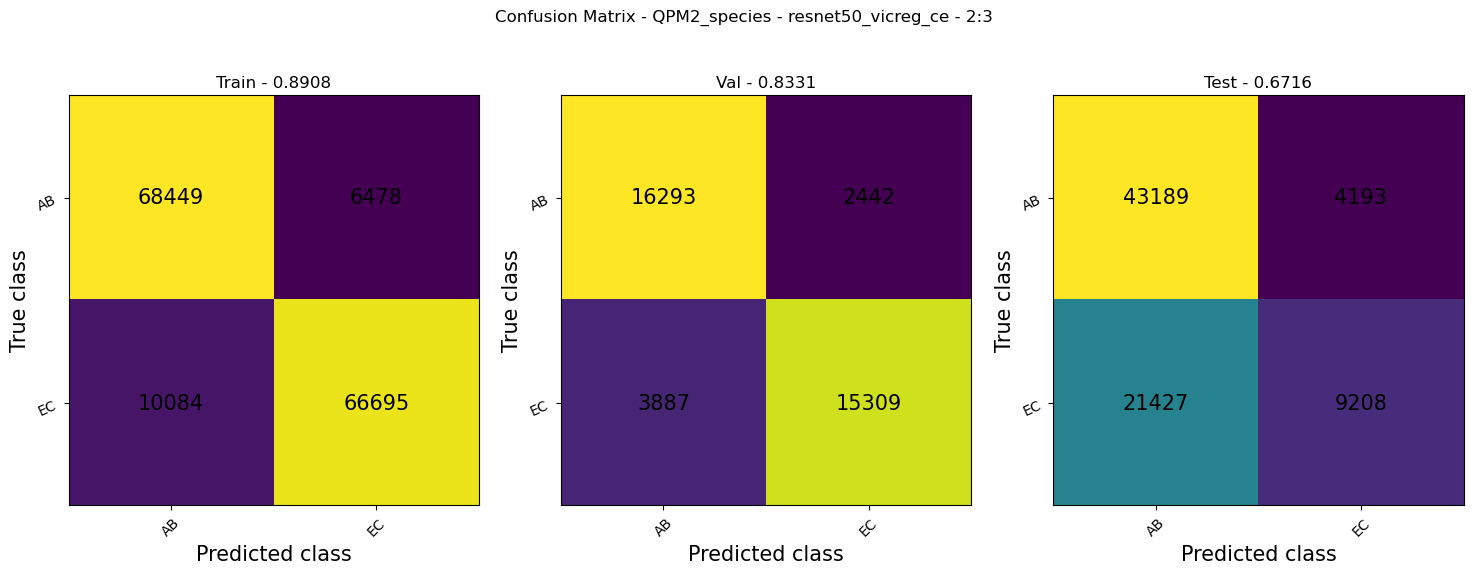

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)
(78017, 2) (81589, 2)


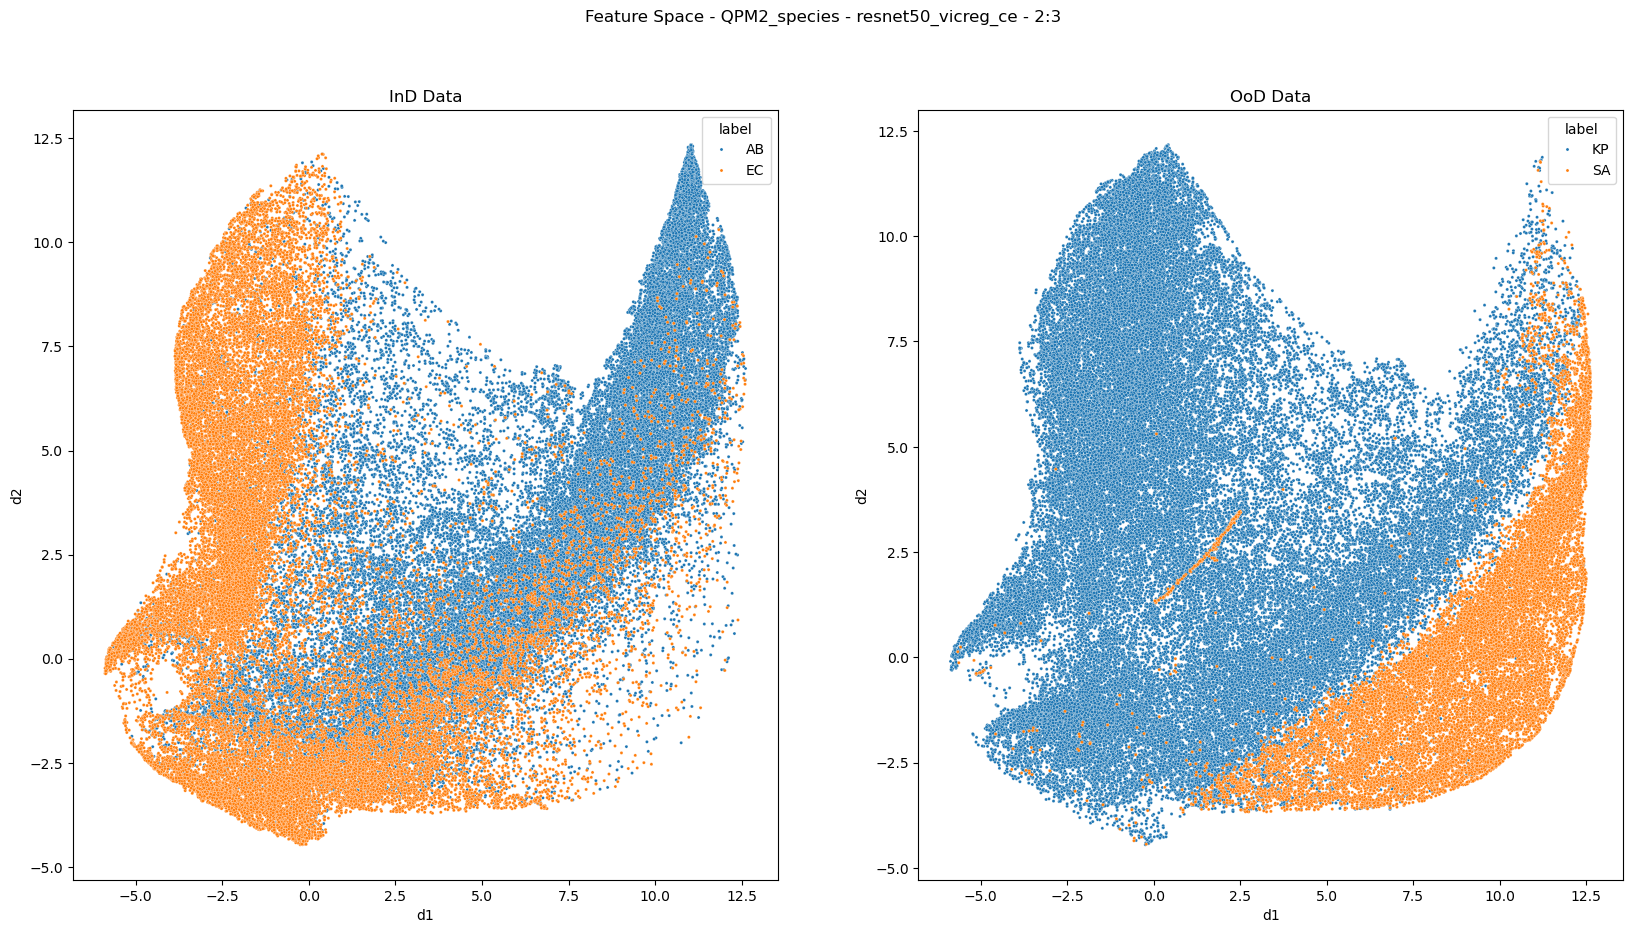

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

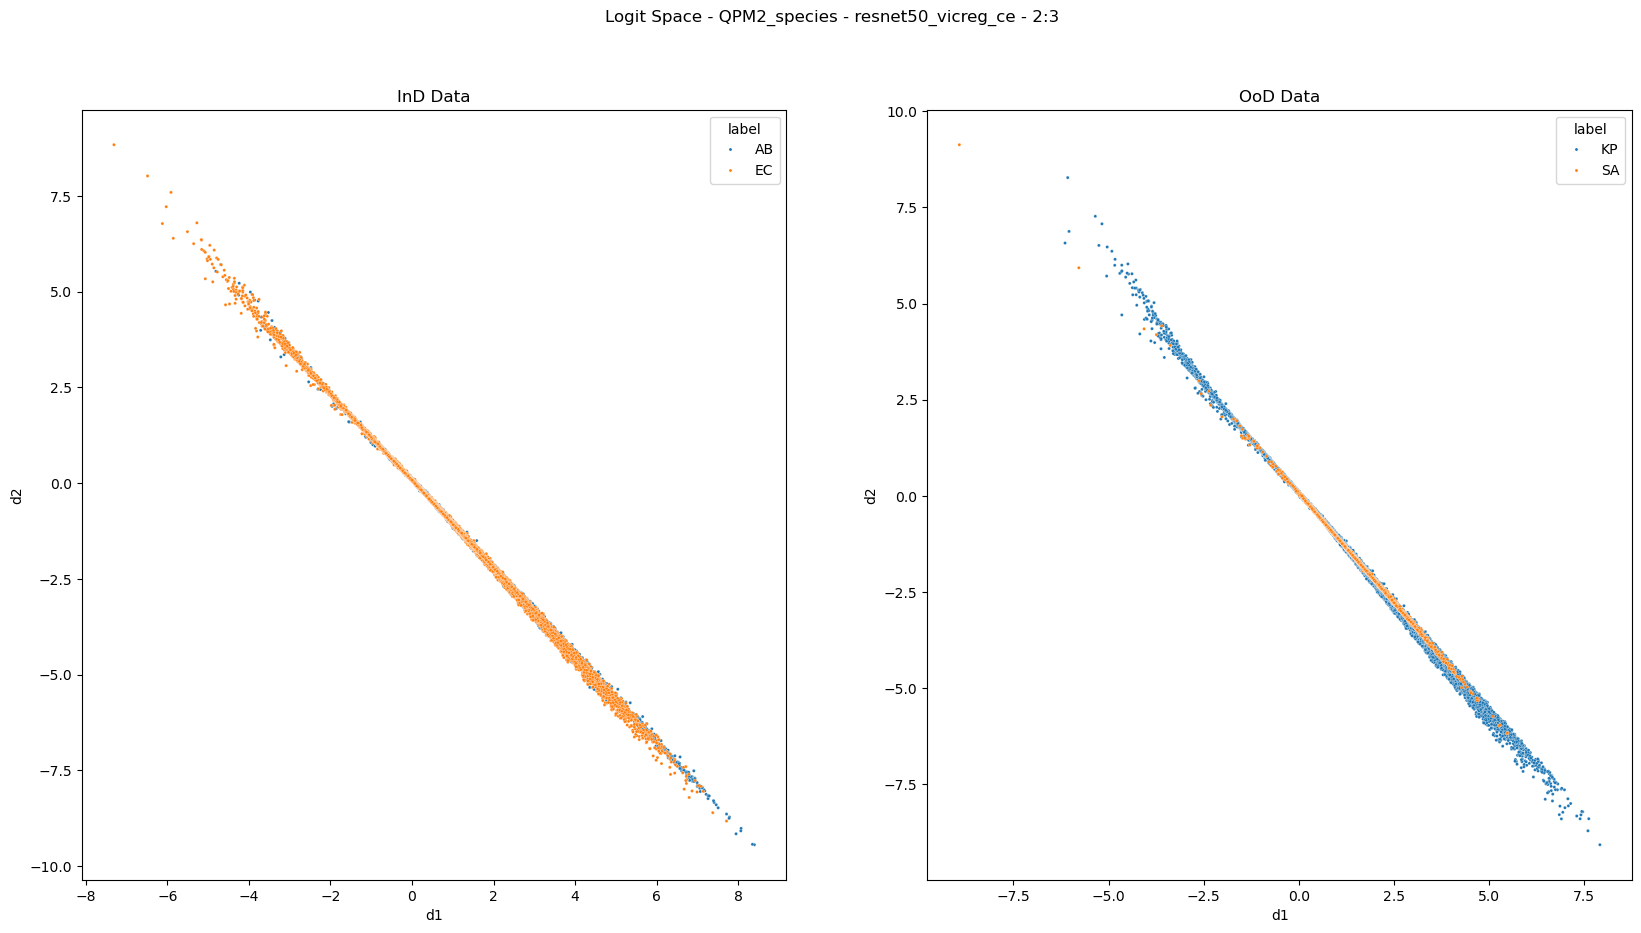

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

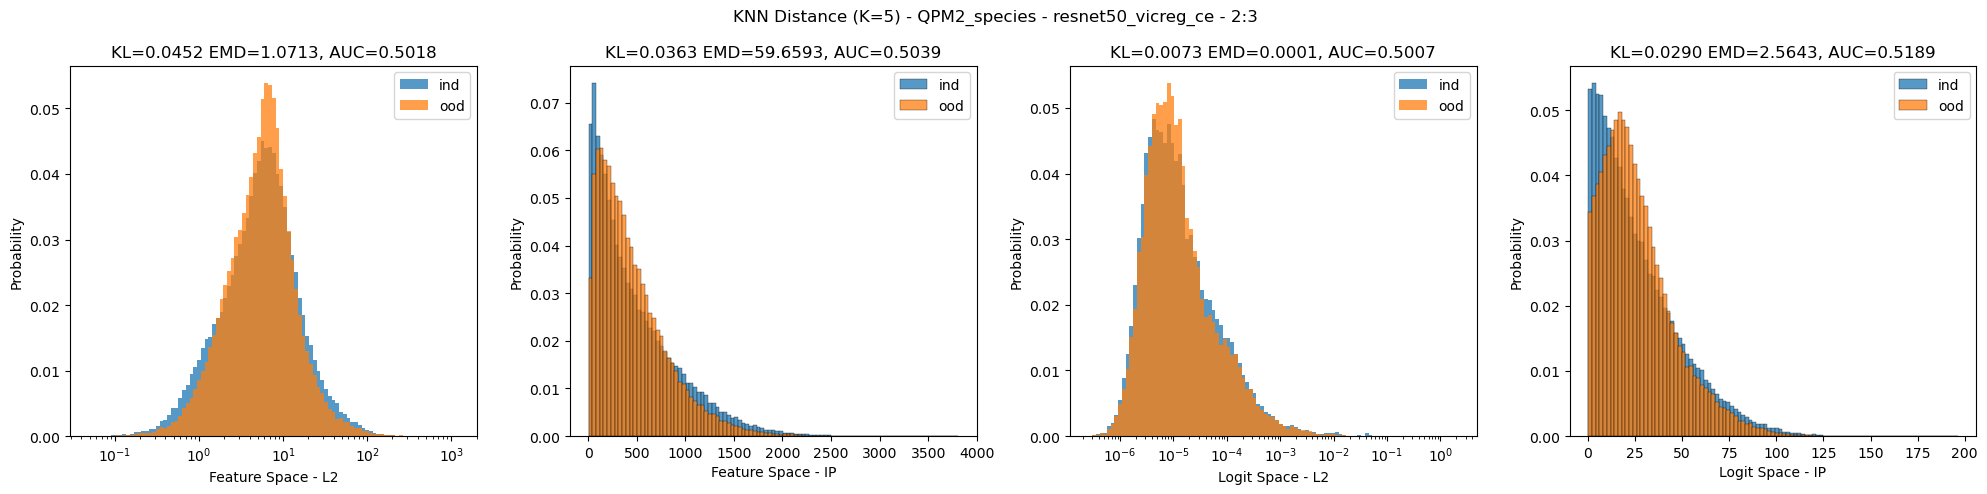

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

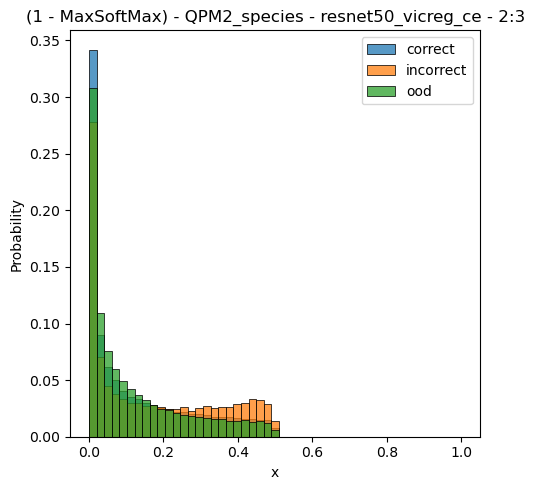

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()